In [1]:
import numpy as np
import pandas as pd
import cv2
import scipy.misc
import matplotlib.pyplot as plt 
import glob
import imageio
import skimage
import skimage.transform
import itertools
#import keras
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

In [2]:
df_movietotal = pd.read_csv("MovieGenre.csv", encoding='latin1')
print(df_movietotal)

       imdbId                           Imdb Link  \
0      114709  http://www.imdb.com/title/tt114709   
1      113497  http://www.imdb.com/title/tt113497   
2      113228  http://www.imdb.com/title/tt113228   
3      114885  http://www.imdb.com/title/tt114885   
4      113041  http://www.imdb.com/title/tt113041   
...       ...                                 ...   
40103   83168   http://www.imdb.com/title/tt83168   
40104   82875   http://www.imdb.com/title/tt82875   
40105  815258  http://www.imdb.com/title/tt815258   
40106   79142   http://www.imdb.com/title/tt79142   
40107   70710   http://www.imdb.com/title/tt70710   

                                    Title  IMDB Score  \
0                        Toy Story (1995)         8.3   
1                          Jumanji (1995)         6.9   
2                 Grumpier Old Men (1995)         6.6   
3                Waiting to Exhale (1995)         5.7   
4      Father of the Bride Part II (1995)         5.9   
...                  

In [3]:
df_movietotal_copy = df_movietotal.copy()
df_movietotal_copy = df_movietotal_copy.dropna(axis=0)

In [4]:
len(df_movietotal_copy)

39246

In [5]:
label_dict = {"word2idx": {}, "idx2word": []}
idx = 0
genre_pm = df_movietotal_copy["Genre"].apply(lambda x: str(x).split("|"))
for l in [g for d in genre_pm for g in d]:
    if l in label_dict["idx2word"]:
        pass
    else:
        label_dict["idx2word"].append(l)
        label_dict["word2idx"][l] = idx
        idx += 1

genre_per_movie = df_movietotal_copy["Genre"].apply(lambda x: str(x).split("|"))

print(genre_per_movie)

0        [Animation, Adventure, Comedy]
1           [Action, Adventure, Family]
2                     [Comedy, Romance]
3              [Comedy, Drama, Romance]
4             [Comedy, Family, Romance]
                      ...              
40102                [Action, Thriller]
40103                           [Drama]
40104                          [Comedy]
40105                          [Horror]
40106                  [Action, Comedy]
Name: Genre, Length: 39246, dtype: object


In [6]:
def genre_count(df, label_dict):
    max_genre = 0
    for label in label_dict["idx2word"]:
        occurrences = len((df[df['Genre'].str.contains(label)]))
        print(label, occurrences)
        if occurrences > max_genre:
            max_genre = occurrences
    return max_genre

max_genre = genre_count(df_movietotal_copy, label_dict)

Animation 1704
Adventure 3806
Comedy 12562
Action 5307
Family 2084
Romance 6188
Drama 19850
Crime 5249
Thriller 4797
Fantasy 2004
Horror 3981
Biography 1971
History 1403
Mystery 2387
Sci-Fi 2002
War 1162
Sport 698
Music 2075
Documentary 3556
Musical 837
Western 846
Short 918
Film-Noir 403
Talk-Show 6
News 79
Adult 9
Reality-TV 2
Game-Show 1


In [7]:
len(df_movietotal_copy)

39246

In [8]:
savelocation = "/Users/Adam/Desktop/Project/Movies/posters/"

image_glob = glob.glob(savelocation + "*.jpg")
img_dict = {}

In [9]:
def get_id(filename):
    index_s = filename.rfind("/") + 1
    index_f = filename.rfind(".jpg")
    return filename[index_s:index_f]

In [10]:
for fn in image_glob:
    try:
        img_dict[get_id(fn)] = imageio.imread(fn)
    except:
        pass

In [11]:
def show_img(idx):
    savelocation = "/Users/Adam/Desktop/Project/Movies/posters/"
    title = np.array(df_movietotal_copy[df_movietotal_copy["imdbId"] == int(idx[8:])]["Title"])[0]
    genre = np.array(df_movietotal_copy[df_movietotal_copy["imdbId"] == int(idx[8:])]["Genre"])[0]
    
    g = genre.split("|")
    
    plt.imshow(img_dict[idx])
    plt.title("{} \n {}".format(title, genre))
    
    return imageio.imread(savelocation + idx[8:] +".jpg"), g

In [12]:
def preprocess(img, size=(150, 101, 3)):
    img = skimage.transform.resize(img, size)
    img = img.astype(np.float32)
    img = (img / 127.5) - 1.
    return img

In [13]:
def prepare_data(data, img_dict, label_dict, size=(150, 101, 3)):
    print("Generation dataset...")
    
    dataset = []
    y = []
    ids = []
    
    n_samples = len(img_dict)
    print("got {} posters".format(n_samples))
    
    count = 0
    
    for key, value in img_dict.items():
        
        if int(key[8:]) in data["imdbId"].values:
            G = data[data["imdbId"] == int(key[8:])]["Genre"].values
            for g in G: 
                g = g.split("|")
                
                img = preprocess(img_dict[key], size)
                
                if img.shape != (150, 101, 3):
                    continue
                l = np.sum([np.eye( len(label_dict["idx2word"]) , dtype="uint8")[label_dict["word2idx"][s]] for s in g], axis=0)

                y.append(l)
                dataset.append(img)
                ids.append(int(key[8:]))
                            
    print("DONE")
    print(len(dataset))
    return dataset, y, ids

In [14]:
SIZE = (150, 101, 3)
dataset, y, ids =  prepare_data(df_movietotal_copy, img_dict, label_dict, size=SIZE)

Generation dataset...
got 38667 posters
DONE
39123


In [15]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

Using TensorFlow backend.


In [16]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(SIZE[0], SIZE[1], 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(28, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adagrad(), metrics=['accuracy'])

In [18]:
n = 4000
model.fit(np.array(dataset[: n]), np.array(y[: n]), batch_size=16, epochs=5, verbose=1, validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Train on 3600 samples, validate on 400 samples
Epoch 1/5
3600/3600 [==============================] - 297s 83ms/step - loss: 0.2933 - accuracy: 0.9126 - val_loss: 0.2146 - val_accuracy: 0.9225
Epoch 2/5
3600/3600 [==============================] - 292s 81ms/step - loss: 0.2275 - accuracy: 0.9198 - val_loss: 0.2138 - val_accuracy: 0.9225
Epoch 3/5
3600/3600 [==============================] - 287s 80ms/step - loss: 0.2247 - accuracy: 0.9200 - val_loss: 0.2128 - val_accuracy: 0.9191
Epoch 4/5
3600/3600 [==============================] - 286s 79ms/step - loss: 0.2234 - accuracy: 0.9196 - val_loss: 0.2129 - val_accuracy: 0.9225
Epoch 5/5
3600/3600 [==============================] - 291s 81ms/step - loss: 0.2218 - accuracy: 0.9200 - val_loss: 0.2121 - val_accuracy: 0.9225


In [19]:
n_test = 100
X_test = dataset[n:n + n_test]
y_test = np.array(y[n:n + n_test])

In [20]:
pred = model.predict(np.array(X_test))

In [21]:
def largest_ele(l, n):
    l = l.copy()
    s = []
    
    for i in range(n):
        num = np.argmax(l)
        s.append(num)
        l[num] = 0

    return np.array(s)

In [22]:
def accuracy_score(y_test, pred):
    value = 0
    num_of_gen = 0
    for i in range(len(pred)):
        correct = np.array(np.where(y_test[i] == 1))
        correct = correct[0]
        perdicted = np.sort(largest_ele(pred[i], len(correct)))
        
        num_of_gen = 0
        
        for j in range(len(correct)):
            for k in range(len(perdicted)):
                if(perdicted[k] == correct[j]):
                    num_of_gen = num_of_gen + 1

        num_of_gen = num_of_gen / len(correct)
        
        value = value + num_of_gen
            
    print(value/len(pred))

In [23]:
accuracy_score(y_test, pred)

0.44166666666666676


Original genres: 
Documentary
Biography
Music

Predicted genres: 
Comedy
Action
Drama


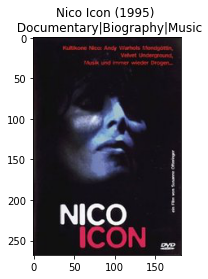

In [32]:
from IPython.display import clear_output

def GenrePerdictor(img):
    print("Original genres: ")
    img, genre = show_img("posters" + "\\" + img)
    for i in genre:
        print(i)
    
    dataset = []
    img = preprocess(img)
    dataset.append(img)
    
    pred = model.predict(np.array(dataset))

    perdicted = np.sort(largest_ele(pred[0], len(genre)))
    
    print("")
    print("Predicted genres: ")
    for i in perdicted:
        print(label_dict["idx2word"][i])

img = input("Enter image name: ")
clear_output(wait=True)

GenrePerdictor(img)